# Deep Neural Networks
What if we need to tackle complex problems, such as detecting hundreds of types of objects in high-resolution images? We need to train a **deeper** ANN, perhaps with 10 layers or many more, each containing hundreds of neurons, linked by hundreds of thousands of connections. However, training a **Deep Deep Neural Network (DNN)** rise some problems:
- the gradients can grow smaller and smaller, or larger and larger, when flowing backward through the DNN during training, making lower layers very hard to train (***vanishing/explodin gradients***);
- we might not have enough training data for such a large network, or it might be too costly to label;
- training may be extremely slow;
- a model with millions of parameters would severely risk overfitting the training set.

In the following we will go through each of these problems and present techniques to solve them. 

1. [The Vanishing Exploding Gradients Problems](#The-Vanishing-Exploding-Gradients-Problems)
    - [Initialization strategies](#Initialization-strategies)
    - [Nonsaturating Activation Functions](#Nonsaturating-Activation-Functions)
    - [Batch Normalization](#Batch-Normalization)
    - [Gradient Clipping](#Gradient-Clipping)
2. [Transfer Learning](#Transfer-Learning)
3. [Faster Optimization](#Faster-Optimization)
    - [Momentum Optimization](#Momentum-Optimization)
    - [Nesterov Accelerated Gradient](#Nesterov-Accelerated-Gradient)
    - [AdaGrad](#AdaGrad)
    - [RMSProp](#RMSProp)
    - [Adam](#Adam)
    - [Higher orders derivatives](#Higher-orders-derivatives)
    - [Remarks](#Remarks)
4. [Learning Rate Scheduling](#Learning-Rate-Scheduling)
    - [Power scheduling](#Power-scheduling)
    - [Exponential scheduling](#Exponential-scheduling)
    - [Piecewise constant scheduling](#Piecewise-constant-scheduling)
    - [Performance scheduling](#Performance-scheduling)
    - [Comparison](#Comparison)
5. [Regularization](#Regularization)
    - [Early stopping](#Early-stopping)
    - [L1 and L2 regularization](#L1-and-L2-regularization)
    - [Dropout](#Dropout)
    - [Monte Carlo Dropout](#Monte-Carlo-Dropout)
    - [MaxNorm Regularization](#MaxNorm-Regularization)
6. [Summary and Practical Guidelines](#Summary-and-Practical-Guidelines)
5. [Exercise](#Exercise)


In [1]:
import sklearn
import tensorflow as tf
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## The Vanishing Exploding Gradients Problems
The backpropagation algorithm works by going from the output layer to the input layer, propagating the error gradient along the way. Once the algorithm has computed the gradient of the cost function with regard to each parameter in the network, it uses these gradients to update each parameter with a Gradient Descent step.

Unfortunately, gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, the Gradient Descent update leaves the lower layers’ connection weights virtually unchanged, and training never converges to a good solution. We call this the **vanishing
gradients problem**. 

In some cases, the opposite can happen: the gradients can grow bigger and bigger until layers get insanely large weight update and the algorithm diverges. This is the **exploding gradients problem**, which
surfaces in recurrent neural networks. 

More generally, DNN suffer from **unstable gradients**.

The problem is due to  the combination of the logistic sigmoid activation function and the weight initialization technique (i.e., a normal distribution with a mean of 0 and a standard deviation of 1). 

It can be showed that with this combination, the variance of the outputs of each layer is much greater than the variance of its inputs. Going forward in the network, the variance keeps increasing after each layer until the activation function saturates at the top layers. This saturation is actually made worse by the fact that the logistic function has a mean of 0.5, not 0.

For a detailed matematical description, see the paper [Xavier Glorot and Yoshua Bengio, **Understanding the Difficulty of Training Deep Feedforward Neural Networks**, Proceedings of the 13th International Conference on Artificial Intelligence and Statistics (2010)](http://proceedings.mlr.press/v9/glorot10a.html)

Looking at the logistic activation function, we can see that when inputs become large (negative or positive), the function saturates at 0 or 1, with a derivative extremely close to 0:

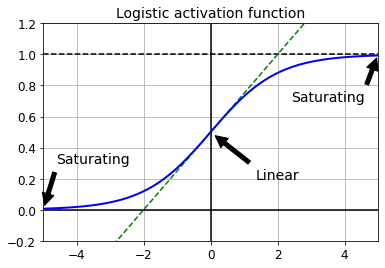

In [2]:
def logit(x):
    return 1 / (1 + np.exp(-x))

x = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(x, logit(x), "b-", linewidth=2)

props = dict(facecolor='black', shrink=0.1)

plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")

plt.grid(True)
plt.title("Logistic activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

Thus, when backpropagation kicks in it has virtually no gradient to propagate back through the network; and what little gradient exists keeps getting diluted as backpropagation progresses down through the top layers, so there is really nothing left for the lower layers.

### Initialization strategies
In order to alleviate the unstable gradients problem, we need the signal to flow properly in both directions: in the forward direction when making predictions, and in the reverse direction when backpropagating gradients. 

We don’t want the signal to die out, nor do we want it to explode and saturate. For the signal to flow properly, we need the variance of the outputs of each layer to be equal to the variance of its inputs, and we need the gradients to have equal variance before and after flowing through a layer in the reverse direction. 

It is not possible to guarantee both unless the layer has an equal number of inputs and neurons (these numbers are called the **fan-in** and **fan-out** of the layer). A good compromise that has proven to work well in practice: the connection weights of each layer must be initialized randomly as described in the following equations

- $ \text{Normal distribution with mean 0 and variance } \sigma^2=\frac{1}{\text{fan}_\text{avg}}$  
- $ \text{Uniform distribution between } -r \text{ and } +r \text{ with } r=\sqrt{\frac{3}{\text{fan}_\text{avg}} } $
- $ \text{where } \text{fan}_\text{avg}=(\text{fan}_\text{in}+\text{fan}_\text{out})/2$

This initialization strategy is called **Xavier initialization** or **Glorot initialization**.

Some papers have provided similar strategies for different activation functions. 

By default, Keras uses Glorot initialization with a uniform distribution, however it support a number of other strategies. When creating a layer, we can change the initialization stratergy by setting **kernel_initializer** parameter.

In [3]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

### Nonsaturating Activation Functions
The problem with unstable gradients is in part due to a poor choice of activation function. The sigmoid activation function (used in biological neurons) is not the best choice. The **ReLU activation function** is fast to compute and does not saturate for positive values. Unfortunately, it is not perfect. It suffers from a problem known as the **dying ReLUs**: during training, some neurons “die” (they stop outputting anything other than 0). This happens when the neuron weights get tweaked in a way that the weighted sum of inputs are negative for all instances in the training set. In these conditions, the neuron just keeps outputting zeros, and Gradient Descent does not affect it anymore because the gradient of the ReLU function is zero when its input is negative.

To solve this problem, we can use a variant of the ReLU function: the **leaky ReLU**. 

$\text{LeakyReLU}(x)=\text{max}(\alpha x, x)$ 

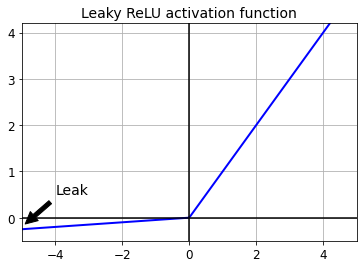

In [4]:
def leaky_relu(x, alpha=0.01):
    return np.maximum(alpha*x, x)

plt.plot(x, leaky_relu(x, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

The hyperparameter $\alpha$ defines how much the function “leaks”: it is the slope of the function for z < 0. This small slope ensures that leaky ReLUs never die; they can go into a long coma, but they have a chance to eventually wake up. 

Other variants are: the **randomized leaky ReLU (RReLU)**, where $\alpha$ is picked randomly in a given range during training and is fixed to an average value during testing, and the **parametric leaky ReLU (PReLU)**, where $\alpha$ is authorized to be learned during training. For a comparison of several variants of the ReLU activation function, we can refer to the paper:[Bing Xu et al. **Empirical Evaluation of Rectified Activations in Convolutional Network** arXiv preprint arXiv:1505.00853 (2015)](https://arxiv.org/pdf/1505.00853.pdf)

In Keras, to use the leaky ReLU activation function, we can just create a LeakyReLU layer and add it to our model just after the layer we want to apply it to.

Another possibility is to use the **exponential linear unit (ELU)** activation function, that outperform ReLU variants: 

$\text{ELU}_\alpha(x) = 
\begin{cases}
    \alpha(\text{exp}(x)-1 & \text{if} & x \lt 0 \\
     x & \text{if} & x \gt 0
\end{cases}$




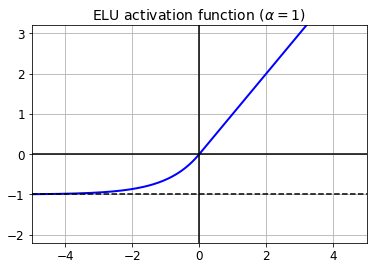

In [5]:
def elu(x, alpha=1):
    return np.where(x < 0, alpha * (np.exp(x) - 1), x)

plt.plot(x, elu(x), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

The main drawback of the ELU activation function is that it is slower to compute than the ReLU functions (due to the use of the exponential function). Its faster convergence rate during training compensates for that slow computation, but still, at test time an ELU network will be slower than a ReLU network.

Finally, the **Scaled ELU (SELU)** activation function is a variant of the ELU activation function. For a neural network composed exclusively of a stack of dense layers, the SELU activation function allows a self-normalization:
the output of each layer will tend to preserve a mean of 0 and standard deviation of 1 during training, which solves the vanishing/exploding gradients problem. As a result, the SELU activation function often significantly outperforms other activation functions for such neural nets.

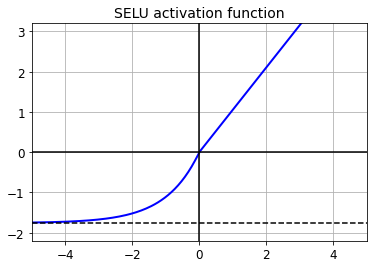

In [6]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

def selu(x, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(x, alpha)

plt.plot(x, selu(x), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

So, which activation function should we use? In general SELU -> ELU -> leaky ReLU (and its variants) -> ReLU -> tanh > logistic. However, because ReLU is the most used activation function, many libraries and hardware accelerators provide ReLU-specific optimizations; therefore, if speed is a priority, ReLU might  be the best choice.

An update list of activation functions with refereces can be accessed [here](https://paperswithcode.com/methods/category/activation-functions)

Let's train a neural network on Fashion MNIST using different activation functions.

**1) Leaky ReLU**

In [7]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [8]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [9]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [10]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 2s 878us/step - loss: 1.2743 - accuracy: 0.6130 - val_loss: 0.8752 - val_accuracy: 0.7250
Epoch 2/10
1719/1719 [==============================] - 1s 812us/step - loss: 0.7895 - accuracy: 0.7429 - val_loss: 0.7044 - val_accuracy: 0.7762
Epoch 3/10
1719/1719 [==============================] - 1s 814us/step - loss: 0.6791 - accuracy: 0.7745 - val_loss: 0.6314 - val_accuracy: 0.7960
Epoch 4/10
1719/1719 [==============================] - 1s 820us/step - loss: 0.6212 - accuracy: 0.7928 - val_loss: 0.5904 - val_accuracy: 0.8096
Epoch 5/10
1719/1719 [==============================] - 1s 820us/step - loss: 0.5843 - accuracy: 0.8050 - val_loss: 0.5607 - val_accuracy: 0.8150
Epoch 6/10
1719/1719 [==============================] - 1s 834us/step - loss: 0.5575 - accuracy: 0.8130 - val_loss: 0.5371 - val_accuracy: 0.8244
Epoch 7/10
1719/1719 [==============================] - 1s 814us/step - loss: 0.5377 - accuracy: 0.8205 - val_loss: 0.5188 -

**2) Leaky PReLU**

In [11]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [12]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [13]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 2s 953us/step - loss: 1.4294 - accuracy: 0.5748 - val_loss: 0.9422 - val_accuracy: 0.7078
Epoch 2/10
1719/1719 [==============================] - 2s 925us/step - loss: 0.8367 - accuracy: 0.7343 - val_loss: 0.7381 - val_accuracy: 0.7656
Epoch 3/10
1719/1719 [==============================] - 2s 912us/step - loss: 0.7064 - accuracy: 0.7716 - val_loss: 0.6550 - val_accuracy: 0.7862
Epoch 4/10
1719/1719 [==============================] - 2s 903us/step - loss: 0.6386 - accuracy: 0.7916 - val_loss: 0.5994 - val_accuracy: 0.8034
Epoch 5/10
1719/1719 [==============================] - 2s 932us/step - loss: 0.5955 - accuracy: 0.8040 - val_loss: 0.5640 - val_accuracy: 0.8208
Epoch 6/10
1719/1719 [==============================] - 2s 913us/step - loss: 0.5651 - accuracy: 0.8128 - val_loss: 0.5382 - val_accuracy: 0.8260
Epoch 7/10
1719/1719 [==============================] - 2s 920us/step - loss: 0.5429 - accuracy: 0.8176 - val_loss: 0.5195 -

**3) SELU (with 100 hidden layers)**

In [14]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [15]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [16]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [17]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 11s 6ms/step - loss: 0.9661 - accuracy: 0.6285 - val_loss: 0.7183 - val_accuracy: 0.7312
Epoch 2/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.6572 - accuracy: 0.7659 - val_loss: 0.6298 - val_accuracy: 0.7804
Epoch 3/5
1719/1719 [==============================] - 11s 6ms/step - loss: 0.6931 - accuracy: 0.7527 - val_loss: 1.1169 - val_accuracy: 0.7006
Epoch 4/5
1719/1719 [==============================] - 12s 7ms/step - loss: 0.7993 - accuracy: 0.7246 - val_loss: 0.7850 - val_accuracy: 0.7318
Epoch 5/5
1719/1719 [==============================] - 11s 6ms/step - loss: 0.8747 - accuracy: 0.6790 - val_loss: 0.8143 - val_accuracy: 0.6766


Now look at what happens if we try to use the ReLU activation function with 100 hidden layers:

In [18]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [19]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [20]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 9s 5ms/step - loss: 1.8988 - accuracy: 0.2553 - val_loss: 1.3451 - val_accuracy: 0.4562
Epoch 2/5
1719/1719 [==============================] - 9s 5ms/step - loss: 1.2564 - accuracy: 0.4710 - val_loss: 1.1376 - val_accuracy: 0.4636
Epoch 3/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.9766 - accuracy: 0.5870 - val_loss: 0.8601 - val_accuracy: 0.6506
Epoch 4/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.8390 - accuracy: 0.6529 - val_loss: 0.7783 - val_accuracy: 0.6848
Epoch 5/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.7797 - accuracy: 0.6988 - val_loss: 0.8253 - val_accuracy: 0.6862


Not great at all, we suffered from the vanishing/exploding gradients problem.

### Batch Normalization

Initialization techniques andELU (or variant of ReLU) can significantly reduce the the vanishing/exploding gradients problems at the beginning of training, however it doesn’t guarantee that they won’t come back during training.
**Batch Normalization** (BN) technique consists of adding an operation in the model before or after the activation function of each hidden layer. This operation **zerocenters and normalizes** each input, then scales and shifts the result using
two new parameters (to be learned during backpropagation). Often, if we add a BN layer as first layer, we do not need to standardize the training set; the BN layer will do it (approximately, since it only looks at one batch at a time).

In order to zero-center and normalize the inputs, the algorithm needs to estimate each input’s mean and standard deviation. It does so by evaluating the mean and standard deviation of the input over the current mini-batch (hence the name “Batch Normalization”):

$\begin{align}
\mu_{B}=\frac{1}{m_B}\sum\limits_{i=1}^{m_B}{x^{(i)}}
\end{align}$ 

$\begin{align}
\sigma _B^2 =\frac{1}{m_B}\sum\limits_{i=1}^{m_B}{(x^{(i)}-\mu _B)^2}
\end{align}$ 

$\begin{align}
\hat{x}^{(i)} =\frac{x^{(i)}-\mu _B}{\sqrt{\sigma _B^2+\epsilon}} 
\end{align}$

$\begin{align}
z^{(i)}=\gamma \otimes \hat{x}^{(i)}+\beta 
\end{align}$

where:
- $B$ is the mini-batch
- $m_B$ is the number of instances in the mini-batch
- $\mu_{B}$ is the vector of input means, evaluated over the mini-batch
- $\sigma_B$ is the vector of input standard deviations, evaluated over the minibatch
- $\hat{x}^{(i)}$ is the vector of zero-centered and normalized inputs for instance i
- $\gamma$ is the scale parameter vector for the layer
- $\beta$ is the shift parameter vector for the layer
- $\epsilon$ is a tiny number (smoothing term) to avoids division by zero
- $z^{(i)}$ is the output of the BN operation: a rescaled and shifted version of the inputs.

So during training, BN standardizes its inputs, then rescales and offsets
them. But what about at prediction time? We may need to make predictions for individual instances or over small batch of instances, so computing statistics would be unreliable. 

One solution could be to wait until the end of training, then run the whole training set through the neural network and compute the mean and standard deviation of each input of the BN layer. These “final” input means and standard deviations could then be used instead of the batch ones when making predictions. 

Most implementations of BN (also Keras) estimate these "final" statistics during training by using a moving average of the layer’s input means and standard deviations.

The paper [Sergey Ioffe and Christian Szegedy **Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift** Proceedings of the 32nd International Conference on Machine Learning (2015)](https://arxiv.org/abs/1502.03167) shows tha BN considerably improve DNN, in particular leading to a huge improvement in the [ImageNet](http://www.image-net.org/) classification task. 

BN, however, adds some complexity to the model and there is a runtime penalty: the NN makes slower predictions due to the extra computations required at each layer. Fortunately, it’s  possible to fuse the BN layer with the previous layer, after training, in order to avoid the runtime penalty. This is done by updating the previous layer’s weights and biases so that it directly produces outputs of the appropriate scale and offset. The previous laryer computes: 

$\begin{align}
XW+b
\end{align}$

the BN layers computes (ignoring the smoothing term): 

$\begin{align}
\gamma \otimes \frac{(XW+b-\mu)}{\sigma} + \beta
\end{align}$

If we define:

$\begin{align}
W' = \gamma \otimes \frac{W}{\sigma}
\end{align}$

$\begin{align}
b'= \gamma \otimes \frac{(b-\mu)}{\sigma} +\beta
\end{align}$

the equation simplifies to

$\begin{align}
XW'+b'
\end{align}$

So, if we replace the previous layer’s weights and biases ($W$ and $b$) with the updated weights and biases ($W'$ and $b'$), we can get rid of the BN layer.

In Keras, we can use BN just adding a **BatchNormalization** layer before or after each hidden layer activation function. As an example, the following model applies BN after every hidden layer and as the first layer (after flattening the input images): 

In [21]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In tiny example with just two hidden layers, it’s unlikely that BN will have a positive impact, but for deeper networks it can make a tremendous difference.

In [22]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_208 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_209 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_210 (Dense)            (None, 10)               

As we can see, each BN layer adds four parameters per input ($\gamma$, $\beta$, $\mu$, and $\sigma$), the first BN layer adds 3.136 parameters (which is 4x784). The last two parameters ($\mu$, and $\sigma$) are the moving averages and they are not affected by backpropagation, so Keras calls them **non-trainable** (3.136 + 1.200 + 400)/2=2.368

In [23]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.8207 - accuracy: 0.7272 - val_loss: 0.5385 - val_accuracy: 0.8208
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5607 - accuracy: 0.8067 - val_loss: 0.4672 - val_accuracy: 0.8418
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5059 - accuracy: 0.8235 - val_loss: 0.4333 - val_accuracy: 0.8524
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4742 - accuracy: 0.8345 - val_loss: 0.4137 - val_accuracy: 0.8600
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4525 - accuracy: 0.8414 - val_loss: 0.4014 - val_accuracy: 0.8630
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4342 - accuracy: 0.8474 - val_loss: 0.3884 - val_accuracy: 0.8656
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4220 - accuracy: 0.8533 - val_loss: 0.3819 - val_accuracy:

Sometimes applying BN before the activation function works better, there's a debate on this topic:

In [24]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 1.0846 - accuracy: 0.6596 - val_loss: 0.6806 - val_accuracy: 0.7862
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6804 - accuracy: 0.7793 - val_loss: 0.5559 - val_accuracy: 0.8176
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5916 - accuracy: 0.8027 - val_loss: 0.5020 - val_accuracy: 0.8314
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5435 - accuracy: 0.8162 - val_loss: 0.4686 - val_accuracy: 0.8432
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5118 - accuracy: 0.8251 - val_loss: 0.4459 - val_accuracy: 0.8502
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4906 - accuracy: 0.8320 - val_loss: 0.4294 - val_accuracy: 0.8568
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4699 - accuracy: 0.8387 - val_loss: 0.4171 - val_accuracy:

BN has become one of the most-used layers in DNN, to the point that it is often omitted in the diagrams, as it is assumed that BN is added after every layer. However, a recent paper [Hongyi Zhang et al. **Fixup Initialization: Residual Learning Without Normalization** arXiv preprint arXiv:1901.09321 (2019)](https://arxiv.org/abs/1901.09321) may change this assumption: by using a novel weight initialization technique, the authors managed to train a very deep NN (10,000 layers!) without BN, achieving state-of-the-art performance on complex image classification tasks.

### Gradient Clipping

Another popular technique to mitigate the exploding gradients problem is to clip the gradients during backpropagation so that they never exceed some threshold. This technique, called **Gradient Clipping**, was presented in the paper [Razvan Pascanu et al. **On the Difficulty of Training Recurrent Neural Networks** Proceedings of the 30th International Conference on Machine Learning (2013)](https://arxiv.org/abs/1211.5063) and it is most often used in recurrent neural networks, for other types of networks, BN is usually sufficient.

In Keras, the use of Gradient Clipping is done by setting **clipvalue** or **clipnorm** arguments when creating an optimizer:

In [25]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="mse", optimizer=optimizer)

This optimizer will clip every component of the gradient vector to a value between –1.0 and 1.0. Note that this may change the orientation of the gradient vector. For instance, if the
original gradient vector is [0.9, 100.0], it points mostly in the direction of the second axis; but once you clip it by value, you get [0.9, 1.0], which points roughly in the diagonal between the two axes. In practice, this approach works well. If we want to ensure that Gradient Clipping does not change the direction of the gradient vector, we can clip by norm by setting clipnorm instead of clipvalue. This will clip the whole gradient if its norm is greater than the threshold.

## Transfer Learning

It is generally not a good idea to train a large DNN from scratch: instead, we can try to find an existing neural network that accomplishes a similar task to the one we are trying to tackle, then reuse the lower layers of this network. This technique is called **transfer learning**. It will not only speedcup training considerably, but also require significantly less training data.

Suppose we have access to a DNN that was trained to classify pictures into 100 different categories (e.g. animals, plants, vehicles, and everyday objects) and we want to train a DNN to classify specific types of vehicles. These tasks are very similar, even partly overlapping, so we can try to reuse parts of the first network.

<img src="transfer-learning.png" width="500">

The output layer of the original model should usually be replaced because it is most likely not useful at all for the new task, and it may not even have the right number of outputs for the new task. Similarly, the upper hidden layers of the original model are less likely to be as useful as the lower layers, since the high-level features that are most useful for the new task may differ significantly from the ones that were most useful for the original task. We have  to find the right number of layers to reuse: the more similar the tasks are, the more layers we can reuse (starting with the lower layers). For very similar tasks, we can try to keep all the hidden layers and just replace the output layer.

Let's look at a simple example in order to show how Transfer Learning can be implemented in Keras. Suppose someone has built a model on a simpler Fashion MNIST dataset (one with only eight classes, all the classes except for sandal and shirt). Let’s call this model A. We now want to tackle a different task: we have images of sandals and shirts, and we want to train a binary classifier (positive=shirt, negative=sandal). That task is quite similar to the first one, so we can try transfer learning.

Let's split the fashion MNIST training set in two:
- X_train_A: all images of all items except for sandals and shirts (classes 5 and 6)
- X_train_B: a much smaller training set of just the first 200 images of sandals or shirts

In [26]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [27]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [28]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 1s 973us/step - loss: 0.6087 - accuracy: 0.8035 - val_loss: 0.3900 - val_accuracy: 0.8625
Epoch 2/20
1375/1375 [==============================] - 1s 892us/step - loss: 0.3626 - accuracy: 0.8756 - val_loss: 0.3363 - val_accuracy: 0.8764
Epoch 3/20
1375/1375 [==============================] - 1s 885us/step - loss: 0.3232 - accuracy: 0.8887 - val_loss: 0.3071 - val_accuracy: 0.8916
Epoch 4/20
1375/1375 [==============================] - 1s 890us/step - loss: 0.3031 - accuracy: 0.8950 - val_loss: 0.2925 - val_accuracy: 0.8991
Epoch 5/20
1375/1375 [==============================] - 1s 886us/step - loss: 0.2890 - accuracy: 0.9002 - val_loss: 0.2872 - val_accuracy: 0.8986
Epoch 6/20
1375/1375 [==============================] - 1s 889us/step - loss: 0.2791 - accuracy: 0.9041 - val_loss: 0.2795 - val_accuracy: 0.9028
Epoch 7/20
1375/1375 [==============================] - 1s 884us/step - loss: 0.2707 - accuracy: 0.9078 - val_loss: 0.2681 -

Now we create a new model (model B) based on that model A layers, let’s reuse all the layers except for the output layer. We can train model B for task B, but since the new output layer was initialized randomly, it will make large errors, so there will be large error gradients that may wreck the reused weights. To avoid this, one approach is to freeze the reused layers during the first few epochs, giving the new layer some time to learn reasonable weights. To do this, we have to set every layer’s trainable attribute to false, compile the model and train it for a few epochs; then unfreeze the reused layers (which requires compiling the model again) and continue training to fine-tune the reused layers for task B.

In [29]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())
model_B = keras.models.Sequential(model_A_clone.layers[:-1])
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

for layer in model_B.layers[:-1]:
    layer.trainable = False

model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

history = model_B.fit(X_train_B, y_train_B, epochs=4,
                      validation_data=(X_valid_B, y_valid_B))

for layer in model_B.layers[:-1]:
    layer.trainable = True

model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

history = model_B.fit(X_train_B, y_train_B, epochs=16,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 18ms/step - loss: 0.6857 - accuracy: 0.5950 - val_loss: 0.6873 - val_accuracy: 0.6024
Epoch 2/4
7/7 [==============================] - 0s 5ms/step - loss: 0.6125 - accuracy: 0.6700 - val_loss: 0.6227 - val_accuracy: 0.6744
Epoch 3/4
7/7 [==============================] - 0s 5ms/step - loss: 0.5522 - accuracy: 0.7200 - val_loss: 0.5673 - val_accuracy: 0.7323
Epoch 4/4
7/7 [==============================] - 0s 5ms/step - loss: 0.5007 - accuracy: 0.8050 - val_loss: 0.5203 - val_accuracy: 0.7698
Epoch 1/16
7/7 [==============================] - 0s 18ms/step - loss: 0.4000 - accuracy: 0.8800 - val_loss: 0.3507 - val_accuracy: 0.8955
Epoch 2/16
7/7 [==============================] - 0s 5ms/step - loss: 0.2824 - accuracy: 0.9500 - val_loss: 0.2683 - val_accuracy: 0.9452
Epoch 3/16
7/7 [==============================] - 0s 5ms/step - loss: 0.2175 - accuracy: 0.9600 - val_loss: 0.2175 - val_accuracy: 0.9574
Epoch 4/16
7/7 [====================

So, what’s the final verdict? We can compare with a network learned from scratch:

In [30]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 0s 18ms/step - loss: 0.9043 - accuracy: 0.4700 - val_loss: 0.7915 - val_accuracy: 0.5213
Epoch 2/20
7/7 [==============================] - 0s 5ms/step - loss: 0.7158 - accuracy: 0.6150 - val_loss: 0.6530 - val_accuracy: 0.6268
Epoch 3/20
7/7 [==============================] - 0s 5ms/step - loss: 0.5870 - accuracy: 0.6850 - val_loss: 0.5427 - val_accuracy: 0.7170
Epoch 4/20
7/7 [==============================] - 0s 5ms/step - loss: 0.4858 - accuracy: 0.7650 - val_loss: 0.4640 - val_accuracy: 0.7982
Epoch 5/20
7/7 [==============================] - 0s 5ms/step - loss: 0.4124 - accuracy: 0.8200 - val_loss: 0.4019 - val_accuracy: 0.8550
Epoch 6/20
7/7 [==============================] - 0s 5ms/step - loss: 0.3545 - accuracy: 0.8850 - val_loss: 0.3522 - val_accuracy: 0.9026
Epoch 7/20
7/7 [==============================] - 0s 5ms/step - loss: 0.3055 - accuracy: 0.9250 - val_loss: 0.3134 - val_accuracy: 0.9300
Epoch 8/20
7/7 [=================

If you try to change the classes or the random seed, you will see that the improvement generally drops, or even vanishes or reverses.

It turns out that transfer learning does not work very well with small dense networks, presumably because small networks learn few patterns, and dense networks learn very specific patterns, which are unlikely to be useful in other tasks. Transfer learning works best with deep convolutional neural networks, which tend to learn feature detectors that are much more general (especially in the lower layers). 

## Faster Optimization

Training large DNNs can be painfully slow. A huge speed boost comes from using a
faster optimizer than the regular Gradient Descent optimizer. In this section we will present the most popular algorithms: momentum optimization, Nesterov Accelerated Gradient, AdaGrad, RMSProp, and finally Adam and Nadam optimization.

### Momentum Optimization

Imagine a bowling ball rolling down a gentle slope on a smooth surface: it will start out slowly, but it will quickly pick up momentum until it eventually reaches terminal velocity. In contrast, regular Gradient Descent will simply take small, regular steps down the slope, so the algorithm will take much more time to reach the bottom.

Recall that Gradient Descent updates the weights by subtracting the gradient of the cost function with regard to the weight multiplied by the learning rate:

$\theta = \theta - \eta \nabla J(\theta)$

It does not care about what the earlier gradients were. If the local gradient is tiny, it goes very slowly.

Momentum optimization ([Boris T. Polyak **Some Methods of Speeding Up the Convergence of Iteration Methods** USSR Computational Mathematics and Mathematical Physics 4, no. 5 (1964)](https://vsokolov.org/courses/750/files/polyak64.pdf)) cares a great deal about what previous gradients were: at each iteration, it subtracts the local gradient from the momentum vector $m$ and it updates the weights by adding this momentum:

$1.\quad m \longleftarrow \beta m - \eta \nabla_{\theta} J(\theta)$

$2.\quad \theta \longleftarrow \theta + m$

In other words, the gradient is **used for acceleration, not for speed**. To simulate some sort of friction mechanism and prevent the momentum from growing too large, the algorithm introduces a new hyperparameter $\beta$, called the **momentum**, which must be set between 0 (high friction) and 1 (no friction). A typicalvmomentum value is 0.9.

In order to use momentum optimization in Keras, we have to use the SGD optimizer and set its **momentum hyperparameter**:

In [31]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

### Nesterov Accelerated Gradient

The **Nesterov Accelerated Gradient (NAG**) method ([Yurii Nesterov **A Method for Unconstrained Convex Minimization Problem with the Rate of Convergence** Doklady AN USSR 269 (1983)](http://mpawankumar.info/teaching/cdt-big-data/nesterov83.pdf)), is a small variant to momentum optimization which measures the gradient of the cost function not at the local position but slightly ahead in the direction of the momentum, at:

$1.\quad m \longleftarrow \beta m - \eta \nabla_{\theta} J(\theta + \beta m)$

$2.\quad \theta \longleftarrow \theta + m$

This small tweak works because in general the momentum vector will be pointing in the right direction (toward the optimum), so it will be slightly more accurate to use the gradient measured a bit farther in that direction rather than the gradient at the original position:  

<img src="nesterov.png" width="500">


To use it, simply set **nesterov=True** when creating the SGD optimizer:

In [32]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

### AdaGrad

Consider the elongated bowl problem again: Gradient Descent starts by quickly going down the steepest slope, which does not point straight toward the global optimum, then it very slowly goes down to the bottom of the valley. It would be nice if the algorithm could correct its direction earlier to point a bit more toward the global optimum. The **AdaGrad algorithm** ([John Duchi et al. **Adaptive Subgradient Methods for Online Learning and Stochastic Optimization** Journal of Machine Learning Research 12 (2011)](https://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)) achieves this correction by scaling down the gradient vector along the
steepest dimensions:

$1.\quad s \longleftarrow s + \nabla_{\theta} J(\theta) \otimes \nabla_{\theta} J(\theta)$

$2.\quad  \theta \longleftarrow \theta - \eta \nabla_{\theta} J(\theta) \oslash \sqrt{s + \epsilon}$

The first step accumulates the square of the gradients into the vector $s$, the second step is almost identical to Gradient Descent, but the gradient vector is scaled down by a factor of $\sqrt{s + \epsilon}$ ($\epsilon$ is a smoothing term to avoid division by zero. 

The vectorized form is equivalent to simultaneously computing:

$\begin{align}
s_i \longleftarrow s_i + (\frac{\partial J(\theta}{\partial \theta_i})^2
\end{align}$

$\begin{align}
\theta_i \longleftarrow \theta_i - \frac{\eta}{\sqrt{s_i + \epsilon}} \frac{\partial J(\theta)}{\partial \theta_i}
\end{align}$

In short, this algorithm decays the learning rate, but it does so faster for steep dimensions than for dimensions with gentler slopes. This is called an **adaptive learning rate**. It helps point the resulting updates more directly toward the global optimum.

<img src="adagrad.png" width="500">

AdaGrad frequently performs well for simple quadratic problems, but it often stops too early when training neural networks. The learning rate gets scaled down so much that the algorithm ends up stopping entirely before reaching the global optimum. You  should not use it to train deep neural networks (it may be efficient for simpler tasks such as Linear Regression). Still, understanding AdaGrad is helpful to grasp the other adaptive learning rate optimizers.

Keras has an Adagrad optimizer: 

In [33]:
optimizer = keras.optimizers.Adagrad(lr=0.001)

### RMSProp

The **RMSProp algorithm** ([Geoffrey Hinton, Coursera class on neural networks] (https://homl.info/57)) fixes the AdaGrad risk of slowing down a bit too fast by accumulating only the gradients from the most recent iterations (as opposed to all the gradients since the beginning of training). It does so by using exponential decay in the first step:


$1.\quad s \longleftarrow \beta s + (1-\beta)\nabla_{\theta} J(\theta) \otimes \nabla_{\theta} J(\theta)$

$2.\quad \theta \longleftarrow \theta - \eta \nabla_{\theta} J(\theta) \oslash \sqrt{s + \epsilon}$

The decay rate $β$ is typically set to 0.9, and it is a new hyperparameter, but this default value often works well, so we may not need to tune it at all. Except on very simple problems, this optimizer almost always performs much better than AdaGrad. 

Keras has an RMSprop optimizer:

In [34]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

### Adam

The Adaptive Moment Estimation **Adam algorithm** ([Diederik P. Kingma and Jimmy Ba. **Adam: A Method for Stochastic Optimization** arXiv preprint arXiv:1412.6980 (2014)](https://arxiv.org/abs/1412.6980)) combines the ideas of momentum optimization and RMSProp: just like momentum optimization, it keeps track of an exponentially decaying average of past gradients; and just like RMSProp, it keeps track of an exponentially decaying average of past squared gradients.

$1.\quad m \longleftarrow \beta_1 m - (1-\beta_1) \nabla_{\theta} J(\theta)$

$2.\quad  s \longleftarrow \beta_2 s + (1-\beta_2)\nabla_{\theta} J(\theta) \otimes \nabla_{\theta} J(\theta)$

$\begin{align}
3.\quad 
\hat{m} \longleftarrow \frac{m}{1-\beta_1^T} \quad T:\text{interation number}
\end{align}$

$\begin{align}
4.\quad 
\hat{s} \longleftarrow \frac{s}{1-\beta_2^T}
\end{align}$

$5.\quad  \theta \longleftarrow \theta + \eta \hat{m} \oslash \sqrt{\hat{s} + \epsilon}$


Keras has an Adam optimizer:

In [35]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

We can mention a variants of Adam, called **Nadam algorithm** ([Timothy Dozat **Incorporating Nesterov Momentum into Adam** (2016)](http://cs229.stanford.edu/proj2015/054_report.pdf)) which include the the Nesterov trick in Adam.

### Higher orders derivatives

All the optimization techniques discussed so far only rely on the first-order partial derivatives (**Jacobians**). The optimization literature also contains amazing algorithms based on the second-order partial derivatives (the **Hessians**, which are the partial derivatives of the Jacobians). Unfortunately, these algorithms are very hard to apply to deep neural networks because there are $n^2$ Hessians per output (where $n$ is the number of parameters), as opposed to just $n$ Jacobians per output. Since DNNs typically have tens of thousands of parameters, the second-order optimization algorithms often don’t even fit in memory, and even when they do, computing the Hessians is just too slow.

### Remarks

All these adaptive optimization methods  are often great, converging fast to a good solution. However, this paper [Ashia C. Wilson et al. **The Marginal Value of Adaptive Gradient Methods in Machine Learning** Advances in Neural Information Processing Systems 30 (2017): 4148–4158.](https://arxiv.org/abs/1705.08292) showed that they can lead to solutions that generalize poorly on some datasets. 

So when we are disappointed by our model’s performance, we can try using plain Nesterov Accelerated Gradient instead: our  dataset may just be allergic to adaptive
gradients. Also check out the latest research, because it’s moving fast.

## Learning Rate Scheduling

Finding a good learning rate is very important: 
- if we set it much too high, training may diverge; 
- if we set it too low, training will eventually converge to the optimum, but it will take a very long time; 
- if we set it slightly too high, it will make progress very quickly at first, but it will end up dancing around the optimum, never really settling down

We can find a good learning rate by training the model for a few hundred iterations, exponentially increasing the learning rate from a very small value to a very large value, and then looking at the learning curve and picking a learning rate slightly lower than the one at which the learning curve starts shooting back up. we can then
reinitialize our model and train it with that learning rate.

But we can do better than a constant learning rate: if we start with a large learning rate and then reduce it once training stops making fast progress, we can reach a good solution faster than with the optimal constant learning rate. 

<img src="learning-rate.png" width="500">

There are many different strategies, called **learning schedule** to reduce the learning rate during training.

### Power scheduling

Set the learning rate to a function of the iteration number $t$: 

$\begin{align}
\eta(t) = \frac{\eta_0}{(1+t/s)^c}
\end{align}$

The initial learning rate $\eta_0$ , the power $c$ (typically set to 1), and the steps $s$ are hyperparameters. The learning rate drops at each step. After $s$ steps, it is down to $\eta_0/2$. After $s$ more steps, it is down to $\eta_0/3$,
then it goes down to $\eta_0/4$, then $\eta_0/5$, and so on. As you can see, this schedule first drops quickly, then more and more slowly. Of course, power scheduling requires tuning $\eta$ and $s$ and $c$.

To implement power scheduling in Keras, you have to set the **decay hyperparameter** when creating an optimizer (the decay is the inverse of $s$ and Keras assumes $c=1$):

In [37]:
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

In [49]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 2s 957us/step - loss: 0.6873 - accuracy: 0.7570 - val_loss: 0.5159 - val_accuracy: 0.8256
Epoch 2/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4948 - accuracy: 0.8244 - val_loss: 0.4653 - val_accuracy: 0.8414
Epoch 3/25
1719/1719 [==============================] - 2s 930us/step - loss: 0.4543 - accuracy: 0.8396 - val_loss: 0.4412 - val_accuracy: 0.8498
Epoch 4/25
1719/1719 [==============================] - 2s 899us/step - loss: 0.4312 - accuracy: 0.8483 - val_loss: 0.4240 - val_accuracy: 0.8570
Epoch 5/25
1719/1719 [==============================] - 2s 894us/step - loss: 0.4153 - accuracy: 0.8540 - val_loss: 0.4146 - val_accuracy: 0.8620
Epoch 6/25
1719/1719 [==============================] - 2s 902us/step - loss: 0.4025 - accuracy: 0.8592 - val_loss: 0.4054 - val_accuracy: 0.8626
Epoch 7/25
1719/1719 [==============================] - 1s 856us/step - loss: 0.3927 - accuracy: 0.8625 - val_loss: 0.3985 - v

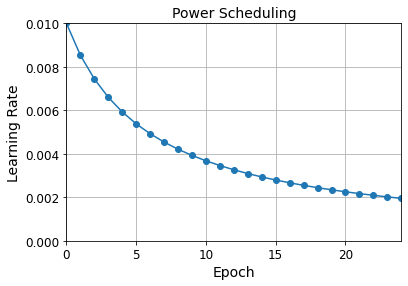

In [51]:
learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential scheduling

Set the learning rate to 

$\eta(t) = \eta_0 0.1^{t/s}$ 

The learning rate will gradually drop by a factor of 10 every $s$ steps. While power scheduling reduces the learning rate more and more slowly, exponential scheduling keeps slashing it by a factor of 10 every $s$ steps.

To implement exponential scheduling in Keras, you need to define a function that takes the current epoch and returns the learning rate, then create a **LearningRateScheduler callback**, giving it the schedule function, and pass this callback to the fit() method.

In [47]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [52]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.8541 - accuracy: 0.7548 - val_loss: 0.7697 - val_accuracy: 0.7716
Epoch 2/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.7129 - accuracy: 0.7873 - val_loss: 1.1835 - val_accuracy: 0.6618
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6578 - accuracy: 0.7993 - val_loss: 0.5880 - val_accuracy: 0.8334
Epoch 4/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.5435 - accuracy: 0.8340 - val_loss: 0.5926 - val_accuracy: 0.8274
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4891 - accuracy: 0.8438 - val_loss: 0.5841 - val_accuracy: 0.8170
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4812 - accuracy: 0.8494 - val_loss: 0.4889 - val_accuracy: 0.8560
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4182 - accuracy: 0.8646 - val_loss: 0.4837 - val_accuracy:

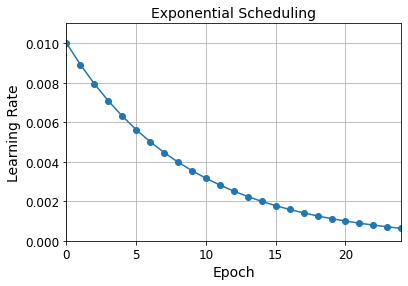

In [53]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Piecewise constant scheduling

Use a constant learning rate for a number of epochs (e.g., $\eta=0.1$ for 5 epochs), then a smaller learning rate for another number of epochs (e.g., $\eta=0.001$ for 50 epochs), and so on. Although this solution can work very well, it requires fiddling around to figure out the right sequence of learning rates and how long to use each of them.

For using Piecewise constant scheduling with Keras, we can do similar to the previous one:

In [55]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001
    
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

In [56]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8676 - accuracy: 0.7496 - val_loss: 0.8298 - val_accuracy: 0.7782
Epoch 2/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.8535 - accuracy: 0.7474 - val_loss: 1.0883 - val_accuracy: 0.6594
Epoch 3/25
1719/1719 [==============================] - 4s 3ms/step - loss: 1.0013 - accuracy: 0.6868 - val_loss: 1.0355 - val_accuracy: 0.7278
Epoch 4/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.9643 - accuracy: 0.7057 - val_loss: 1.0247 - val_accuracy: 0.6698
Epoch 5/25
1719/1719 [==============================] - 4s 3ms/step - loss: 1.0945 - accuracy: 0.6435 - val_loss: 1.1318 - val_accuracy: 0.5930
Epoch 6/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.9385 - accuracy: 0.6257 - val_loss: 0.8873 - val_accuracy: 0.6412
Epoch 7/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.8517 - accuracy: 0.6602 - val_loss: 0.9160 - val_accuracy:

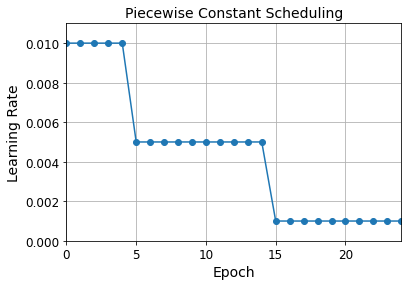

In [57]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Performance scheduling

Measure the validation error every $N$ steps (just like for early stopping), and reduce the learning rate by a factor of $\lambda$ when the error stops dropping.

To use Performance Scheduling in Keras, we can use the **ReduceLROnPlateau callback**:

In [58]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

In [59]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9)

model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

n_epochs = 25

history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5920 - accuracy: 0.8073 - val_loss: 0.5493 - val_accuracy: 0.8152
Epoch 2/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5100 - accuracy: 0.8365 - val_loss: 0.4757 - val_accuracy: 0.8534
Epoch 3/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5033 - accuracy: 0.8439 - val_loss: 0.5757 - val_accuracy: 0.8384
Epoch 4/25
1719/1719 [==============================] - 2s 955us/step - loss: 0.5065 - accuracy: 0.8465 - val_loss: 0.4976 - val_accuracy: 0.8404
Epoch 5/25
1719/1719 [==============================] - 2s 923us/step - loss: 0.5214 - accuracy: 0.8486 - val_loss: 0.7465 - val_accuracy: 0.8086
Epoch 6/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5009 - accuracy: 0.8541 - val_loss: 0.6929 - val_accuracy: 0.8278
Epoch 7/25
1719/1719 [==============================] - 2s 920us/step - loss: 0.5439 - accuracy: 0.8510 - val_loss: 0.6673 - val_acc

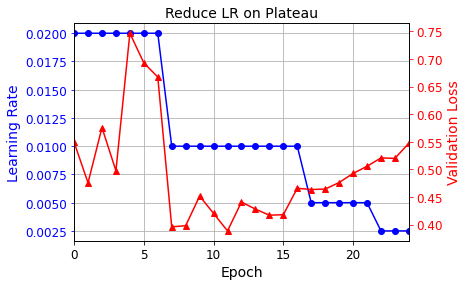

In [60]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### Comparison 

The paper [Andrew Senior et al. **An Empirical Study of Learning Rates in Deep Neural Networks for Speech Recognition** Proceedings of the IEEE International Conference on Acoustics, Speech, and Signal Processing (2013): 6724–6728.](https://ieeexplore.ieee.org/document/6638963) compared the performance of some of the most popular learning schedules when using momentum optimization to train deep neural networks for speech recognition. The authors concluded that, in this setting, both performance scheduling and exponential scheduling performed well. They favored exponential scheduling because it was easy to tune and it converged slightly faster to the optimal solution (they also mentioned that it was easier to implement than performance scheduling, but in Keras both options are easy).

## Regularization

DNNs typically have tens of thousands of parameters (even millions). This gives them an incredible amount of freedom and means they can fit a huge variety of complex datasets. But this great flexibility also makes the network **prone to overfitting** the training set. We need regularization.

### Early stopping

Early stopping is a form of regularization used to avoid overfitting when training a learner with an iterative method, such as gradient descent. Such methods update the learner so as to make it better fit the training data with each iteration. Up to a point, this improves the learner's performance on data outside of the training set. Past that point, however, improving the learner's fit to the training data comes at the expense of increased generalization error. Early stopping rules provide guidance as to how many iterations can be run before the learner begins to over-fit. 

In Keras we can use the **EarlyStopping callback**:

In [80]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=2)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(keras.optimizers.SGD(), loss='mse')

history = model.fit(X_train_scaled, y_train, epochs=250,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[callback])

len(history.history['loss'])

Epoch 1/250
1719/1719 [==============================] - 2s 887us/step - loss: 27.6178 - val_loss: 27.5936
Epoch 2/250
1719/1719 [==============================] - 1s 813us/step - loss: 27.6156 - val_loss: 27.5925
Epoch 3/250
1719/1719 [==============================] - 1s 817us/step - loss: 27.6149 - val_loss: 27.5920
Epoch 4/250
1719/1719 [==============================] - 1s 815us/step - loss: 27.6144 - val_loss: 27.5916
Epoch 5/250
1719/1719 [==============================] - 1s 865us/step - loss: 27.6141 - val_loss: 27.5913
Epoch 6/250
1719/1719 [==============================] - 1s 844us/step - loss: 27.6139 - val_loss: 27.5911
Epoch 7/250
1719/1719 [==============================] - 2s 879us/step - loss: 27.6137 - val_loss: 27.5910
Epoch 8/250
1719/1719 [==============================] - 2s 974us/step - loss: 27.6136 - val_loss: 27.5909
Epoch 9/250
1719/1719 [==============================] - 2s 883us/step - loss: 27.6134 - val_loss: 27.5907
Epoch 10/250
1719/1719 [=============

52

### L1 and L2 regularization

Just like for simple linear models, you can use $\ell_1$ regularization to constrain a neural network’s connection weights, and/or $\ell_2$ regularization if we want a sparse model (with many weights equal to 0). In these methods a regularization term is added to the cost function to forces the learning algorithm to not only fit the data but also keep the model weights as small as possible. 

In Keras we can specify the regularization in that way:

In [81]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

The **l2()** function returns a regularizer that will be called at each step during training to compute the regularization loss. This is then added to the final loss. We can use **keras.regularizers.l1()** if we want $\ell_1$ regularization, if we want both regularization, we can use **keras.regularizers.l1_l2()** function.

Since typically we want to apply the same regularizer to all layers in the network, as well as using the same activation function and the same initialization strategy in all hidden layers, we may find ourself repeating the same arguments. This makes the code ugly and error-prone. To avoid this, we can use Python’s **functools.partial()** function, which lets we create a thin wrapper for any callable, with some default argument values:

In [82]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
            keras.layers.Flatten(input_shape=[28, 28]),
            RegularizedDense(300),
            RegularizedDense(100),
            RegularizedDense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", 
              metrics=["accuracy"])

n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 4s 2ms/step - loss: 1.5936 - accuracy: 0.8121 - val_loss: 0.7835 - val_accuracy: 0.8058
Epoch 2/2
1719/1719 [==============================] - 4s 3ms/step - loss: 0.7172 - accuracy: 0.8270 - val_loss: 0.6900 - val_accuracy: 0.8392


### Dropout
Dropout [Nitish Srivastava et al. **Dropout: A Simple Way to Prevent Neural Networks from Overfitting** Journal of Machine Learning Research (2014)](https://dl.acm.org/doi/10.5555/2627435.2670313) is one of the most popular regularization techniques for deep neural networks.  It is a fairly simple algorithm: at every training step, every neuron (including the input neurons, but always excluding the output neurons) has a probability $p$ of being temporarily “dropped out”, meaning it will be entirely ignored during this training step, but it may be active during the next step. The hyperparameter $p$ is called the **dropout rate** and it is typically set between 10% and 50%. After training, neurons don’t get dropped anymore.

<img src="dropout.png" width="500">

Neurons trained with dropout cannot coadapt with their neighboring neurons; they have to be as useful as possible on their own. They also cannot rely excessively on just a few input neurons; they must pay attention to each of their input neurons. They end up being less sensitive to slight changes in the inputs. In the end, we get a more robust network that generalizes better.

Another way to understand the power of dropout is to realize that a unique neural network is generated at each training step. Since each neuron can be either present or absent, there are a total of $2^N$ possible networks (where N is the total number of droppable neurons). This is such a huge number that it is virtually impossible for the same neural network to be sampled twice. Once you have run 10,000 training steps, you have essentially trained 10,000 different neural networks (each with just one training instance). These neural networks are obviously not independent because they share many of their weights, but they are nevertheless all different. The resulting neural network can be seen as an averaging ensemble of all these smaller
neural networks.

There is one small but important technical detail. Suppose $p=50%$, in which case a durign test neuron would be connected to twice as many input neurons as it would be (on average) during training. To compensate for this fact, we need to multiply each neuron’s input connection weights by 0.5 after training. If we don’t, each neuron will get a total input signal roughly twice as large as what the network was trained on and will be unlikely to perform well. More generally, we need to multiply each input connection weight by the keep probability $(1 – p)$ after training. Alternatively, we can divide each neuron’s output by the keep probability during training (these alternatives are not perfectly equivalent, but they work equally well).

Since dropout is only active during training, comparing the training loss and the
validation loss can be misleading. In particular, a model may be overfitting the training set and yet have similar training and validation losses. So make sure to evaluate the training loss without dropout (e.g., after training).

To implement dropout using Keras, you can use the **keras.layers.Dropout** layer:

In [84]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5754 - accuracy: 0.8031 - val_loss: 0.3748 - val_accuracy: 0.8654
Epoch 2/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4227 - accuracy: 0.8452 - val_loss: 0.3450 - val_accuracy: 0.8700


If we observe that the model is overfitting, we can increase the dropout rate. Conversely, we should try decreasing the dropout rate if the model underfits the training set. It can also help to increase the dropout rate for large layers, and reduce it for small ones. Moreover, many state-of-the-art architectures only use dropout after the last hidden layer, so we may want to try this if full dropout is too strong. Dropout does tend to significantly slow down convergence, but it usually
results in a much better model when tuned properly. So, it is generally well worth the extra time and effort.

If we want to regularize a self-normalizing network based on the SELU activation
function, we should use **alpha dropout**, a variant of dropout that preserves the mean and standard deviation of its inputs (as regular dropout would break self-normalization):

In [85]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])

optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)

model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6646 - accuracy: 0.7583 - val_loss: 0.5628 - val_accuracy: 0.8476
Epoch 2/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5583 - accuracy: 0.7928 - val_loss: 0.5272 - val_accuracy: 0.8488
Epoch 3/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5259 - accuracy: 0.8043 - val_loss: 0.5402 - val_accuracy: 0.8468
Epoch 4/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5068 - accuracy: 0.8124 - val_loss: 0.5033 - val_accuracy: 0.8480
Epoch 5/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4935 - accuracy: 0.8161 - val_loss: 0.4873 - val_accuracy: 0.8498
Epoch 6/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4798 - accuracy: 0.8230 - val_loss: 0.4815 - val_accuracy: 0.8594
Epoch 7/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4692 - accuracy: 0.8274 - val_loss: 0.4325 - val_accuracy:

### Monte Carlo Dropout

Monte Carlo Dropout ([Yarin Gal and Zoubin Ghahramani **Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning** Proceedings of the 33rd International Conference on Machine Learning (2016)](https://arxiv.org/abs/1506.02142)) is a clever realization that the use of the regular dropout can be interpreted as a Bayesian approximation of a well known probabilistic model: the Gaussian process. 

We can treat the many different networks (with different neurons dropped out) as Monte Carlo samples from the space of all available models. This provides mathematical grounds to reason about the model’s uncertainty and, as it turns out, often improves its performance.

How does it work? We simply apply dropout at test time, that's all! Then, instead of one prediction, we get many, one by each model. We can then average them or analyze their distributions. And the best part: it does not require any changes in the model’s architecture. We can even use this trick on a model that has already been trained! To see it working in practice, let’s train a simple network to recognize digits from the MNIST dataset.

We can try to boost the dropout model we trained earlier without retraining it. We just make 100 predictions over the test set, setting training=True to ensure that the Dropout layer is active, and stack the predictions. Since dropout is active, all the predictions will be different. Then we average and we get a prediction. Averaging over multiple predictions with dropout on gives us a Monte Carlo estimate that is generally more reliable than the result of a single prediction with dropout
off.

In [86]:
y_probas = np.stack([model(X_test_scaled, training=True) for sample in range(100)])
y_proba = y_probas.mean(axis=0)

For example, let’s look at the model’s prediction for the first instance in
the test set, with dropout off:

In [87]:
np.round(model.predict(X_test_scaled[:1]), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.98]],
      dtype=float32)

Compare this with the predictions made when dropout is activated:

In [91]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.17, 0.  , 0.25, 0.  , 0.58]],
      dtype=float32)

The model still thinks this image belongs to class 9, but only with a 58% confidence, which seems much more reasonable than 98%. Plus it’s useful to know exactly which other classes it thinks are likely. And you can also take a look at the standard deviation of the probability estimates:

In [92]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.22, 0.  , 0.2 , 0.01, 0.28]],
      dtype=float32)

Apparently there’s quite a lot of variance in the probability estimates: if we were building a risk-sensitive system (e.g., a medical or financial system), we should probably treat such an uncertain prediction with extreme caution.

Moreover, the model’s accuracy got a small boost:

In [95]:
y_pred = np.argmax(y_proba, axis=1)
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8622

The number of samples we use (100 in this example) is a hyperparameter we can tweak. The higher it is, the more accurate the predictions and their uncertainty estimates will be. However, if we double it, inference time will also be doubled. Moreover, above a certain number of samples, we will notice little improvement. So our job is to find the right trade-off between latency and accuracy, depending on our application.

### MaxNorm Regularization

Max-norm regularization* constrains the incoming connection weights $w$ of each neuron $\left\|w\right\|_2 < r$, where $r$ is the **maxnorm hyperparameter**. It does not add a regularization loss term to the overall loss function. Instead, it is typically implemented by computing $\left\|w\right\|_2$ after each training step and rescaling w if needed.

Reducing $r$ increases the amount of regularization and helps reduce overfitting. Max-norm regularization can also help alleviate the unstable gradients problems (if you are not using Batch Normalization).

In Keras, we can set the **kernel_constraint argument** of each hidden layer to a **max_norm()** constraint with the appropriate max value, like this:

In [96]:
keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal",
kernel_constraint=keras.constraints.max_norm(1.))

## Summary and Practical Guidelines

We have covered a wide range of techniques, and you may be wondering which ones you should use. This depends on the task, and there is no clear consensus yet, but the configuration in the following table work fine in most cases, without requiring much hyperparameter tuning:

<img src="guidelines.png" width="500">


Don’t forget to normalize the input features! 

We should also try to reuse parts of a pretrained neural network if we can find one that solves a similar problem.

If we need a sparse model, we can use $\ell_1$ regularization (and optionally zero out the tiny weights after training). If we need an even sparser model, we can use the TensorFlow Model Optimization Toolkit. This will break self-normalization, so we should use the default configuration in this case.

If we need a low-latency model (one that performs lightning-fast predictions), we may need to use fewer layers, fold the Batch Normalization layers into the previous layers, and possibly use a faster activation function such as leaky ReLU or just ReLU.

If we are building a risk-sensitive application, or inference latency is not very important in our application, we can use Monte Carlo Dropout to boost performance and get more reliable probability estimates, along with uncertainty estimates.

Finally, we may want to reduce the float precision from 32 bits to 16 or even 8 bits (e.g. to deploying a model to an embedded Device).

It is possible to create really powerful DNS with Keras, however, we can need even more control (for example, to write a custom loss function or to tweak the training algorithm). For such cases we will need to use TensorFlow’s lower-level API.

## Exercise

**Practice training a deep neural network on the CIFAR10 image dataset. The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes. You can load it with keras.datasets.cifar10.load_ data()**

In [99]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

**1 - Build a DNN with 20 hidden layers of 100 neurons each (that’s too many, but it’s the point of this exercise). Use He initialization and the ELU activation function.**

In [108]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 activation="elu",
                                 kernel_initializer="he_normal"))

**2 - Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You’ll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model’s architecture or hyperparameters.**

In [109]:
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=5e-5)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
callbacks = [early_stopping_cb]

model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 9s 6ms/step - loss: 3.9728 - accuracy: 0.1676 - val_loss: 2.2328 - val_accuracy: 0.2040
Epoch 2/100
1407/1407 [==============================] - 8s 6ms/step - loss: 2.0702 - accuracy: 0.2427 - val_loss: 2.0485 - val_accuracy: 0.2402
Epoch 3/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.9416 - accuracy: 0.2920 - val_loss: 1.9681 - val_accuracy: 0.2964
Epoch 4/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.8585 - accuracy: 0.3220 - val_loss: 1.9178 - val_accuracy: 0.3254
Epoch 5/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.7985 - accuracy: 0.3451 - val_loss: 1.8256 - val_accuracy: 0.3384
Epoch 6/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.7495 - accuracy: 0.3665 - val_loss: 1.7430 - val_accuracy: 0.3692
Epoch 7/100
1407/1407 [==============================] - 8s 6ms/step - loss: 1.7072 - accuracy: 0.3825 - val_loss: 1.7199 - val_ac

**3 - Now try adding Batch Normalization and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?**

In [110]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model.add(keras.layers.BatchNormalization())
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("elu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
callbacks = [early_stopping_cb]

model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 15s 11ms/step - loss: 1.8411 - accuracy: 0.3426 - val_loss: 1.6602 - val_accuracy: 0.4042
Epoch 2/100
1407/1407 [==============================] - 15s 10ms/step - loss: 1.6666 - accuracy: 0.4099 - val_loss: 1.5887 - val_accuracy: 0.4304
Epoch 3/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.5996 - accuracy: 0.4305 - val_loss: 1.5781 - val_accuracy: 0.4326
Epoch 4/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.5511 - accuracy: 0.4499 - val_loss: 1.5064 - val_accuracy: 0.4676
Epoch 5/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.5083 - accuracy: 0.4660 - val_loss: 1.4412 - val_accuracy: 0.4844
Epoch 6/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.4684 - accuracy: 0.4807 - val_loss: 1.4179 - val_accuracy: 0.4984
Epoch 7/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.4370 - accuracy: 0.4914 - val_loss: 1

Is the model converging faster than before? Much faster! The previous model took 39 epochs to reach the lowest validation loss, while the new model with BN took 18 epochs. That's more than twice as fast as the previous model. The BN layers stabilized training and allowed us to use a much larger learning rate, so convergence was faster.

Does BN produce a better model? Yes! The final model is also much better, with 52% accuracy instead of 47%. It's still not a very good model, but at least it's much better than before.

How does BN affect training speed? Although the model converged twice as fast, each epoch took more time, because of the extra computations required by the BN layers. 

**4  - Try replacing Batch Normalization with SELU, and make the necessary adjustements to ensure the network selfnormalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a
sequence of dense layers, etc.)**

In [111]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=7e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
callbacks = [early_stopping_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 6s 4ms/step - loss: 1.9303 - accuracy: 0.3043 - val_loss: 1.7878 - val_accuracy: 0.3552
Epoch 2/100
1407/1407 [==============================] - 6s 4ms/step - loss: 1.7113 - accuracy: 0.3908 - val_loss: 1.7028 - val_accuracy: 0.3828
Epoch 3/100
1407/1407 [==============================] - 6s 4ms/step - loss: 1.6190 - accuracy: 0.4301 - val_loss: 1.6692 - val_accuracy: 0.4022
Epoch 4/100
1407/1407 [==============================] - 6s 4ms/step - loss: 1.5512 - accuracy: 0.4539 - val_loss: 1.6350 - val_accuracy: 0.4300
Epoch 5/100
1407/1407 [==============================] - 6s 4ms/step - loss: 1.4944 - accuracy: 0.4766 - val_loss: 1.5773 - val_accuracy: 0.4356
Epoch 6/100
1407/1407 [==============================] - 6s 4ms/step - loss: 1.4473 - accuracy: 0.4909 - val_loss: 1.5529 - val_accuracy: 0.4630
Epoch 7/100
1407/1407 [==============================] - 6s 4ms/step - loss: 1.4061 - accuracy: 0.5091 - val_loss: 1.5290 - val_ac

We get 51.4% accuracy, which is better than the original model, but not quite as good as the model using batch normalization. Moreover, it took 13 epochs to reach the best model, which is much faster than both the original model and the BN model, plus each epoch took a short time just like the original model. So it's by far the fastest model to train (both in terms of epochs and wall time).

**5 - Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC Dropout.**

In [112]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
callbacks = [early_stopping_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 6s 4ms/step - loss: 1.8973 - accuracy: 0.3245 - val_loss: 1.7629 - val_accuracy: 0.3738
Epoch 2/100
1407/1407 [==============================] - 6s 4ms/step - loss: 1.6695 - accuracy: 0.4080 - val_loss: 1.6333 - val_accuracy: 0.4226
Epoch 3/100
1407/1407 [==============================] - 6s 4ms/step - loss: 1.5810 - accuracy: 0.4441 - val_loss: 1.6475 - val_accuracy: 0.4314
Epoch 4/100
1407/1407 [==============================] - 6s 4ms/step - loss: 1.5112 - accuracy: 0.4739 - val_loss: 1.5459 - val_accuracy: 0.4624
Epoch 5/100
1407/1407 [==============================] - 6s 4ms/step - loss: 1.4553 - accuracy: 0.4964 - val_loss: 1.5467 - val_accuracy: 0.4726
Epoch 6/100
1407/1407 [==============================] - 6s 4ms/step - loss: 1.4119 - accuracy: 0.5046 - val_loss: 1.5186 - val_accuracy: 0.4806
Epoch 7/100
1407/1407 [==============================] - 6s 4ms/step - loss: 1.3637 - accuracy: 0.5257 - val_loss: 1.5568 - val_ac

The model reaches 50.8% accuracy on the validation set. That's very slightly worse than without dropout (51.4%). With an extensive hyperparameter search, it might be possible to do better, but probably not much better in this case.

Let's use MC Dropout now:

In [113]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)
    
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return np.argmax(Y_probas, axis=1)

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = np.mean(y_pred == y_valid[:, 0])
accuracy

0.5048

We only get virtually no accuracy improvement in this case (from 50.8% to 50.9%).
So the best model we got in this exercise is the Batch Normalization model.